In [1]:
# imports
from downsample import *
import pandas as pd
from dask import delayed
import dask.dataframe as dd
import numpy as np

In [2]:
import dask

In [3]:
from dask.diagnostics import Profiler, ResourceProfiler, ProgressBar

In [35]:
#paths
datapath='../../datasets/'
apath = os.path.join(datapath, 'tracks.csv')
bpath = os.path.join(datapath, 'songs.csv')

In [36]:
# load datasets
A = pd.read_csv(apath, low_memory=False)
B = pd.read_csv(bpath, low_memory=False)

In [37]:
def fn(x):
    if not pd.isnull(x):
        return str2bytes(x)
    else:
        return x

In [38]:
for col in get_str_cols(A):
    A[col] = A[col].map(fn)
for col in get_str_cols(B):
    B[col] = B[col].map(fn)
    

In [39]:
spath = os.path.join(datapath, 'stopwords')
stopwords = get_stop_words(spath)
stopwords.extend(['and', 'in', 'the', 'my', 'me', 'to', 'you', 'i', 'andre', 'from', 'a', 'of', 'the', 'version', 'love', 'live', 'la', 'mix', 'album', 'dont'])
stopwords = list(set(stopwords))

In [40]:
# downsample_pandas
import time
def downsample_pandas(A, B, lid, rid, size, yparam, stopwords=[]):
    st=time.time()
    lstrings = preprocess_table(A, lid)
    print('preprocess ltable : {0} secs'.format(time.time()-st))
    
    st=time.time()
    ltokens = tokenize_strings(lstrings, stopwords)
    print('tokenize ltable : {0} secs'.format(time.time()-st))
    
    st = time.time()
    invindex = build_inv_index([ltokens])
    print('invindex ltable : {0} secs'.format(time.time()-st))
    
    
    #rsample = B.sample(size, replace=False)
    rsample = B.head(size)
    
    st = time.time()
    rstrings = preprocess_table(rsample, rid)
    print('preprocess rtable : {0} secs'.format(time.time()-st))
    
    st = time.time()    
    rtokens = tokenize_strings(rstrings, stopwords)
    print('tokenize rtable : {0} secs'.format(time.time()-st))    
    
    st = time.time()    
    probe_result = probe(rtokens, invindex, yparam)
    print('tokenize rtable : {0} secs'.format(time.time()-st))      
    
    st = time.time()
    result = postprocess([probe_result], A, B, lid, rid)
    print('postprocess : {0} secs'.format(time.time()-st))          
    return result

In [8]:
# result = downsample_pandas(A, B, 'id', 'id', 10000, 1, stopwords=stopwords)

In [41]:
def sample(df, size):
    return df.sample(size, replace=False)
def splitdf(df, nchunks):
    sample_splitted = np.array_split(df, nchunks)
    return sample_splitted

In [55]:
# downsample delayed
import numpy as np
def downsample_delayed(A, B, lid, rid, size, yparam, nchunks=1, stopwords=[], compute=False):

    lstrings = delayed(preprocess_table)(A, lid)
    ltokens = delayed(tokenize_strings)(lstrings, stopwords)
    invindex = delayed(build_inv_index)([ltokens])
    
    rsample = delayed(sample)(B, size)
    rsample_splitted = delayed(splitdf)(rsample, nchunks)
    probe_results = []
    
    for i in range(nchunks):
        rstrings = delayed(preprocess_table)(rsample_splitted[i], rid)
        rtokens = delayed(tokenize_strings)(rstrings, stopwords)
        probe_result = delayed(probe)(rtokens, invindex, yparam)
        probe_results.append(probe_result)
    
    result = delayed(postprocess)(probe_results, A, B, lid, rid)
    
    if compute:
        tmp = result.compute()
        return tmp   
    else:
        return result

In [56]:
with ProgressBar():
    del_result = downsample_delayed(A, B, 'id', 'id', 5000, 1, nchunks=4, stopwords=stopwords, compute=True)

[########################################] | 100% Completed | 38.0s


In [58]:
del_result[0].head()

,id,title,year,episode,song,artists
140,140,(Des)encontros,2014.0,Lara e Gael (#1.1),Um Dia A Gente Se Encontra,charlie brown jr.
916,916,20 to 1,2005.0,80s Good Bad & Ugly (#9.15),Thriller,michael jackson+rod temperton
970,970,20 to 1,2005.0,80s Good Bad & Ugly (#9.15),Kiss the Bride,elton john
1721,1721,20 to 1,2005.0,Rock n Roll Anthems (#8.27),All Fired Up,pat benatar+kerryn tolhurst+myron grombacher
1750,1750,20 to 1,2005.0,Scene-Stealing Songs (#8.12),Old Time Rock and Roll,bob seger+george jackson+tom jones iii


In [60]:
del_result = delayed(downsample_delayed)(A, B, 'id', 'id', 5000, 1, nchunks=4, stopwords=stopwords, compute=True)
del_result_1 = delayed(downsample_delayed)(del_result[0], del_result[1], 'id', 'id', 3000, 1, nchunks=4, stopwords=stopwords)

In [70]:
s = dict(del_result_1.dask)

In [71]:
s.keys()

['downsample_delayed-ce250e6b-86d1-4606-91e7-181b96464844',
 'getitem-07b06a58fd5643eafce5f4382a1002ab',
 'downsample_delayed-f8131411-3490-48e5-be6d-656b250e3f22',
 'getitem-b1dfc0f5d04673e34a502bbd3412c9b2']

In [62]:
xx = del_result_1.compute()

In [66]:
yy = xx.compute()

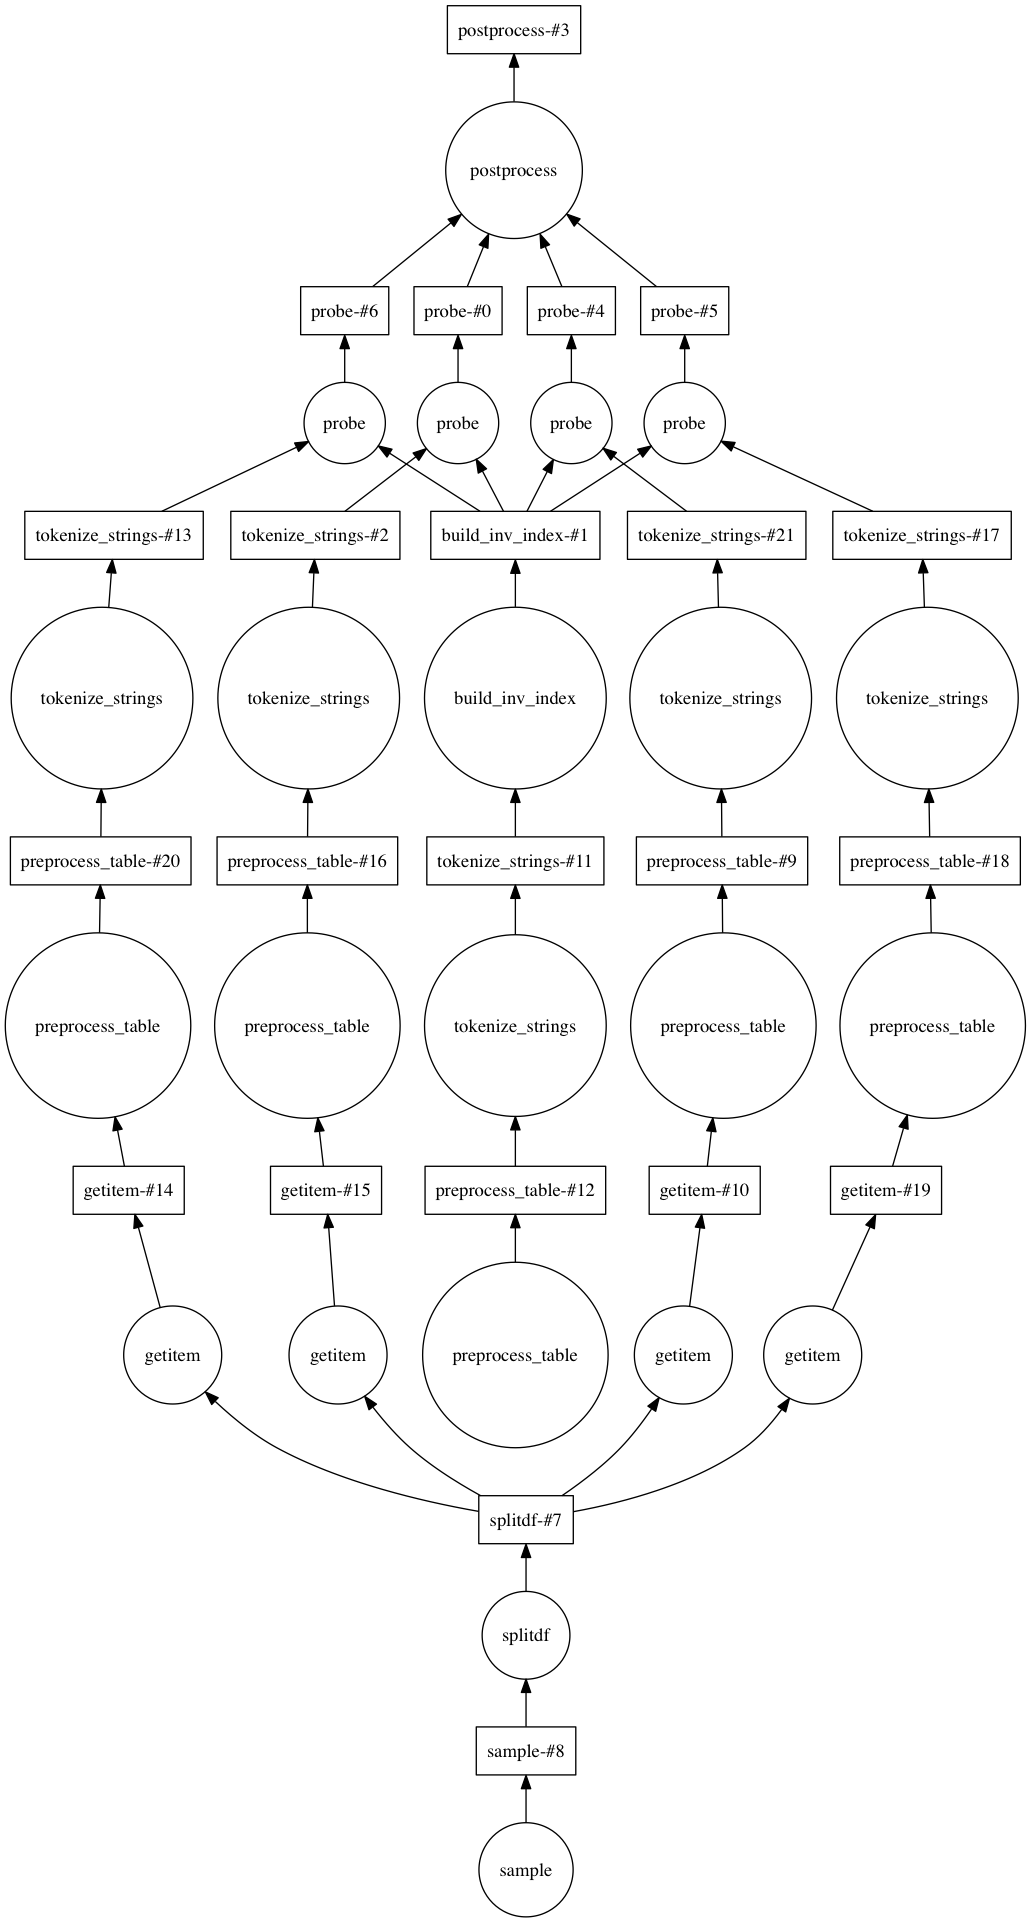

In [68]:
xx.visualize()

In [52]:
with Profiler() as prof, ResourceProfiler() as rprof, ProgressBar():
    r = del_result_1.compute()

[########################################] | 100% Completed | 38.7s


In [53]:
prof.visualize()

Figure(id='8b7d0976-fbc8-435b-b9cc-001d3ee6dd14', ...)

In [14]:
# prof.visualize()